In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

## Data
Data was collected and stored in pickle format using ```music_data.py```. Now this data can be easily loaded and used.

In [3]:
# Load the data
top_tracks_ids_df = pd.read_pickle('spotify_data/top_tracks_ids.pkl')
saved_tracks_ids_df = pd.read_pickle('spotify_data/saved_tracks_ids.pkl')
top_tracks_of_top_artists_df = pd.read_pickle('spotify_data/top_tracks_of_top_artists.pkl')
random_tracks_ids_df = pd.read_pickle('spotify_data/random_tracks_ids.pkl')
tracks_features_df = pd.read_pickle('spotify_data/tracks_features.pkl')
recommended_tracks_df = pd.read_pickle('spotify_data/recommended_tracks.pkl')

In [4]:
# Remove duplicate tracks
top_tracks_ids_df = top_tracks_ids_df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)
saved_tracks_ids_df = saved_tracks_ids_df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)
top_tracks_of_top_artists_df = top_tracks_of_top_artists_df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)
random_tracks_ids_df = random_tracks_ids_df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)
tracks_features_df = tracks_features_df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)
recommended_tracks_df = recommended_tracks_df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

# Remove tracks which are present in both tracks_features_df and recommended_tracks_df
recommended_tracks_df = recommended_tracks_df[~recommended_tracks_df['id'].isin(tracks_features_df['id'].tolist())]

In [5]:
tracks_features_df.head()

,id,popularity,explicit,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,4lsHZ92XCFOQfzJFBTluk8,79,True,203144,0.762,0.433,5,-8.937,1,0.1870,0.1430,0.000000,0.1180,0.394,122.074,4,"[pop r&b, r&b]"
1,3DarAbFujv6eYNliUTyqtz,87,True,208666,0.764,0.705,8,-3.463,1,0.0284,0.2590,0.000089,0.1200,0.781,110.970,4,"[dance pop, pop]"
2,3zYufmyv6HOuiHn1eMR6Ja,63,False,285960,0.586,0.659,0,-7.920,0,0.0304,0.0110,0.000000,0.1060,0.147,111.989,4,"[permanent wave, soft rock, sophisti-pop]"
3,0k4d5YPDr1r7FX77VdqWez,88,True,186173,0.828,0.621,8,-6.414,1,0.0565,0.0164,0.002330,0.0845,0.436,128.986,4,"[dance pop, pop]"
4,5faV0JuyfLNvBpKu7s6mCV,55,False,134931,0.445,0.601,11,-6.633,0,0.0433,0.0124,0.001530,0.3820,0.198,128.179,4,[]


## Making Sense of the Data

The training data will be made using ```tracks_features_df``` which is a collection of user's top tracks, saved tracks, top 10 tracks of user's top artists and some random tracks. All tracks in user's top tracks, saved tracks, top 10 tracks of user's top artists will be labelled as 1 and the random tracks will be labelled as 0.

Once the model has been trained, the tracks in ```recommended_tracks_df``` will be evaluated on and tracks with a high enough probability will be marked and a playlist will be made from them.

## Label the Data

Classifying the tracks in ```tracks_features_df``` as 1 or 0

In [6]:
count = 0
label_list = list()
for id in tracks_features_df.id:
    if id in top_tracks_ids_df.id.values or id in saved_tracks_ids_df.id.values or id in top_tracks_of_top_artists_df.id.values:
        count = count + 1
        # 1 to the tracks from top tracks or saved tracks or top tracks of top artists
        label_list.append(1)
    else:
        # 0 otherwise
        label_list.append(0)

print(f'Number of tracks marked as 1 --> {count}')

# Add new column 'ratings' to the dataframe
tracks_features_df['labels'] = label_list

Number of tracks marked as 1 --> 805


In [7]:
tracks_features_df['labels']

0       1
1       1
2       1
3       1
4       1
       ..
1497    0
1498    0
1499    0
1500    0
1501    0
Name: labels, Length: 1502, dtype: int64

## Features

We have some features like 'danceability', 'energy', 'key' which were pulled directly from the track audio features using the Spotify Web API. But the genres are lists of different generes. We need to seperate all genres and use them as seperate features. We will use one hot encoding to mark a track of that genre (1) or not (0)

In [8]:
# Training data
X = tracks_features_df[['popularity','explicit','duration_ms','danceability', 'energy', 'key', 'loudness', 'mode',
                        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                        'time_signature', 'genre']]

y = tracks_features_df['labels']

# Drop NaN or None
X = X.dropna()
recommended_tracks_df = recommended_tracks_df.dropna()
# save this as evaluation tracks, the models will be tested on this dataset to get recommended tracks
recommended_tracks_df.to_pickle('spotify_data/eval_tracks_df.pkl')

# Create genre columns (one-hot encoding)
X = X.drop('genre', 1).join(X['genre'].str.join('|').str.get_dummies())
X_recommend = recommended_tracks_df.copy()
X_recommend = X_recommend.drop('genre', 1).join(X_recommend['genre'].str.join('|').str.get_dummies())

# Ensure features are consistent across training, test, and evaluation
X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

<ipython-input-8-5c039160032c>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop('genre', 1).join(X['genre'].str.join('|').str.get_dummies())
<ipython-input-8-5c039160032c>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_recommend = X_recommend.drop('genre', 1).join(X_recommend['genre'].str.join('|').str.get_dummies())


In [9]:
print('---Training set info ---')
X_train.info()
print('\n---Testing set info')
X_test.info()
print('\n---Evaluation set info---')
X_recommend.info()

---Training set info ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 1213 to 1379
Columns: 341 entries, popularity to yacht rock
dtypes: bool(1), float64(9), int64(331)
memory usage: 3.1 MB

---Testing set info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 1285 to 318
Columns: 341 entries, popularity to yacht rock
dtypes: bool(1), float64(9), int64(331)
memory usage: 802.2 KB

---Evaluation set info---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7521 entries, 0 to 7938
Columns: 341 entries, popularity to yacht rock
dtypes: bool(1), float64(9), int64(331)
memory usage: 19.8 MB


## Feature Selection

Currently we have 331 features, we will reduce the number of features to better train the model and reduce on computation

Fitting estimator with 341 features.
Fitting estimator with 340 features.
Fitting estimator with 339 features.
Fitting estimator with 338 features.
Fitting estimator with 337 features.
Fitting estimator with 336 features.
Fitting estimator with 335 features.
Fitting estimator with 334 features.
Fitting estimator with 333 features.
Fitting estimator with 332 features.
Fitting estimator with 331 features.
Fitting estimator with 330 features.
Fitting estimator with 329 features.
Fitting estimator with 328 features.
Fitting estimator with 327 features.
Fitting estimator with 326 features.
Fitting estimator with 325 features.
Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Optimal number of features: 316


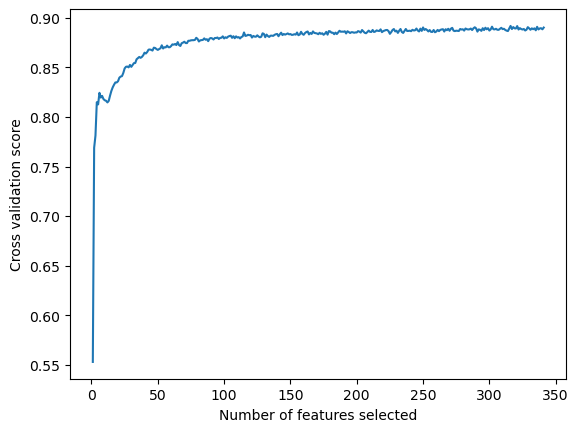

In [75]:
# Recursive Feature Elimination with Cross-Validation (RFECV) is used to rank features
# estimator -> Machine Learning algorithm instance to be used, i have used Random Forest with 1000 trees
# step -> Number of features to remove per iteration
# cv -> cross validation splitting strategy, StratifiedKFold(2) splits data into 2 folds. Works well with imbalance dataset
# scoring -> scoring metric used to optimize for
# verbose --> Setting this to 1 will print updates onto the console on every iteration
# n_jobs --> Number of cores to run in parallel. -1 means all available cores


rf = RandomForestClassifier(n_estimators = 1000, random_state = 20)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(2),  scoring='roc_auc', verbose=1, n_jobs=-1)
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

We can see that the Optimal number of features is 316 whereas the total number of features we have is 331. This means we can get rid of 15 features.

In [82]:
# Dropping the least important features
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_recommend.drop(X_recommend.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

/Users/veersingh/opt/anaconda3/envs/recsysspotify/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [84]:
print('---Training set info ---')
X_train.info()
print('\n---Testing set info')
X_test.info()
print('\n---Evaluation set info---')
X_recommend.info()

---Training set info ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 1213 to 1379
Columns: 316 entries, popularity to yacht rock
dtypes: bool(1), float64(9), int64(306)
memory usage: 2.9 MB

---Testing set info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 1285 to 318
Columns: 316 entries, popularity to yacht rock
dtypes: bool(1), float64(9), int64(306)
memory usage: 743.4 KB

---Evaluation set info---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7521 entries, 0 to 7938
Columns: 316 entries, popularity to yacht rock
dtypes: bool(1), float64(9), int64(306)
memory usage: 18.4 MB


In [85]:
# Saving X_train, y_train, X_test, y_test, X_recommend for use in ML models
X_train.to_csv('model/X_train.csv')
X_train.to_pickle('model/X_train.pkl')

y_train.to_csv('model/y_train.csv')
y_train.to_pickle('model/y_train.pkl')

X_test.to_csv('model/X_test.csv')
X_test.to_pickle('model/X_test.pkl')

y_test.to_csv('model/y_test.csv')
y_test.to_pickle('model/y_test.pkl')

X_recommend.to_csv('model/X_recommend.csv')
X_recommend.to_pickle('model/X_recommend.pkl')

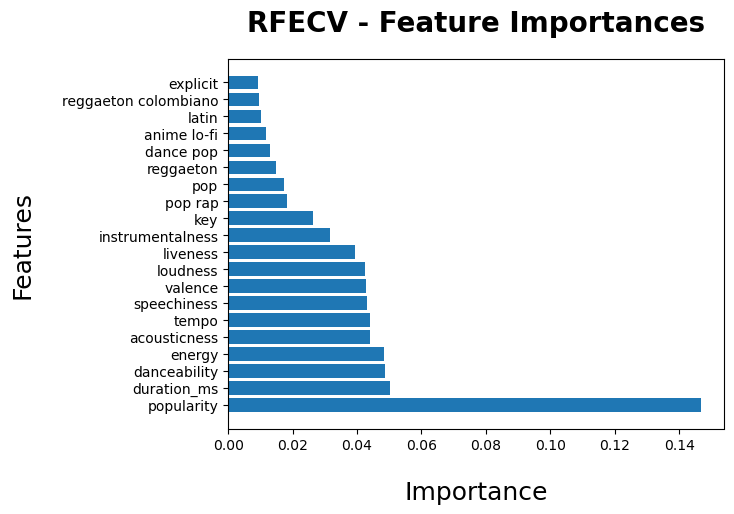

In [86]:
# Visualize importance of 20 of the most important features (showing all XXX would not be possible in such a small space)

X_train = pd.read_pickle('model/X_train.pkl')

dset = pd.DataFrame()
dset['features'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by=['importance'], ascending=False)
dset = dset.head(20)

plt.figure()
plt.barh(y=dset['features'], width=dset['importance'])
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=18, labelpad=20)
plt.ylabel('Features', fontsize=18, labelpad=20)
plt.show()